In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(1234)

# Model 1
from sklearn.decomposition import PCA
from scipy import stats
from scipy.spatial import distance

# Model 1: Hueristic Z-Score Function

Extract relevant features from full data

In [14]:
df = pd.read_csv('features.csv').loc[:, 'RECORD':]

In [15]:
features = df.iloc[:, -45:]

For each record, calculate its z score

In [16]:
for x in features.columns:
    colname = x+'_zscore'
    features[colname] = stats.zscore(features[x])

In [17]:
features_z = features.iloc[:, -45:]

Create a PCA function with 10 components, fit it to z-scaled data

In [18]:
n_components = 10
pca = PCA(n_components=n_components)

features_PCA = pca.fit_transform(features_z)

Create dataframe of principal components as well as the variance explained by each component

In [19]:
PC = ['PC'] * n_components
range_l = [str(x) for x in range(1, n_components+1)]
cols = [i+j for i, j in zip(PC, range_l)]

var_ = pd.DataFrame({'var': pca.explained_variance_ratio_,
                     'PC': cols})

Scree plot

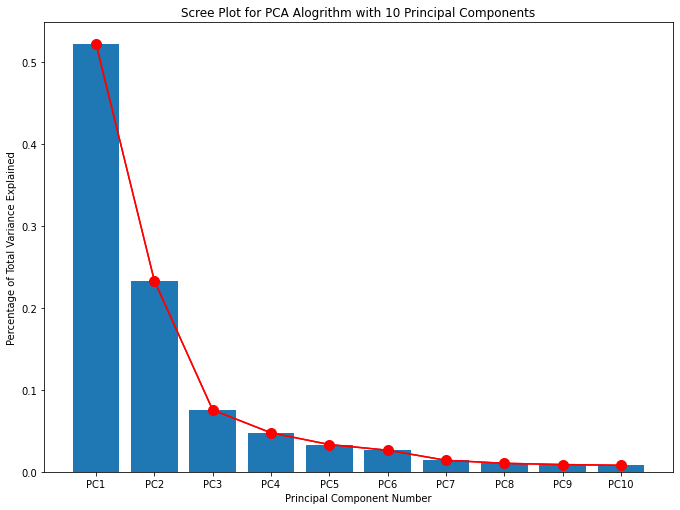

In [24]:
plt.figure(figsize=(11.27,8.27))
plt.bar(x='PC', height='var', data=var_)
plt.plot(var_['PC'], var_['var'], color='red')
plt.plot(var_['PC'], var_['var'], marker='o', markersize=10, color='red')
plt.xlabel('Principal Component Number')
plt.ylabel('Percentage of Total Variance Explained')
plt.title('Scree Plot for PCA Alogrithm with 10 Principal Components')
plt.show()

Find all principal components to keep by looping through until we hit our target of 80%

In [25]:
to_keep = []
count = 0
target = .85
while target >= 0:
    target = target - var_.iloc[count, 0]
    to_keep.append(var_.iloc[count, 1])
    count += 1

In [26]:
pc_to_keep = pd.DataFrame([x[:len(to_keep)] for x in features_PCA], columns=['PC1', 'PC2', 'PC3', 'PC4'])

Z-scale principal componenets

In [27]:
pc_to_keep_z = pc_to_keep.apply(stats.zscore)

Now that each record has a "score" in each dimension, create a function to sum those scores which will define each records fraud score

In [28]:
def euc_sum(vals):
    return (np.abs(sum([x**2 for x in vals])))**(1/2)

In [59]:
pc_to_keep_z['model1_score'] = pc_to_keep_z.apply(euc_sum, axis=1)

In [60]:
pc_to_keep_z

,PC1,PC2,PC3,PC4,SUM,model1_score
0,0.000939,-0.090230,-0.081992,-0.063785,0.137599,0.194594
1,4.199913,16.128732,5.241872,1.222970,17.514227,24.768857
2,0.006287,0.064573,-0.043461,0.010342,0.078772,0.111400
3,0.044381,-0.074404,-0.043499,-0.079560,0.125409,0.177356
4,9.410793,-4.801232,2.740579,-12.562188,16.641340,23.534408
...,...,...,...,...,...,...
1070989,-0.031661,-0.063996,-0.027697,0.015526,0.078142,0.110509
1070990,-0.035513,-0.078378,-0.031540,-0.002969,0.091695,0.129676
1070991,-0.030828,-0.080535,-0.027994,0.000618,0.090666,0.128221
1070992,-0.021493,-0.065886,-0.013105,-0.014869,0.072081,0.101939


<AxesSubplot:xlabel='model1_score', ylabel='Density'>

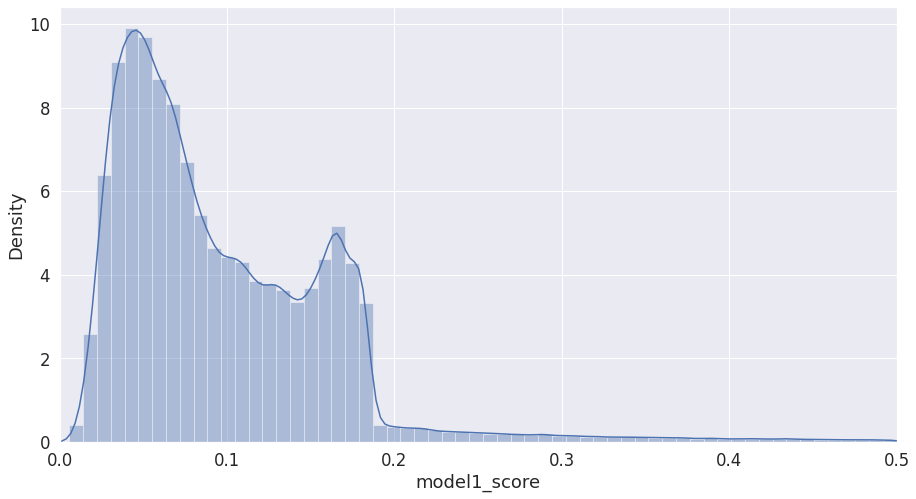

In [62]:
plt.rcParams["figure.figsize"] = [15,8]
sns.set(font_scale=1.5)
xhigh = 0.5
plt.xlim(0,xhigh)
temp = pc_to_keep_z[(pc_to_keep_z['model1_score'] <= xhigh)]
sns.distplot(temp.model1_score, bins = 60, kde=True)